# Outlook

In this notebook we code one of the [Proximal Policy Optimization (PPO)](https://arxiv.org/pdf/1707.06347.pdf) algorithms using BBRL.

The PPO algorithm is superficially explained in [this video](https://www.youtube.com/watch?v=uRNL93jV2HE) and you can also read [the corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/ps/10_ppo.pdf).

It is also a good idea to have a look at the [spinning up documentation](https://spinningup.openai.com/en/latest/algorithms/ppo.html).

## Installation and Imports

### Installation

In [1]:
!pip install easypip

The BBRL library is [here](https://github.com/osigaud/bbrl).

from easypip import easyimport
import functools
import time

easyimport("importlib_metadata==4.13.0")
OmegaConf = easyimport("omegaconf").OmegaConf
bbrl_gym = easyimport("bbrl_gym")
bbrl = easyimport("bbrl>=0.1.6")
```

<!-- #region id="m4kV9pWV3wRe" -->
### Imports
<!-- #endregion -->

<!-- #region id="caqhJYbe5YcO" -->
Below, we import standard python packages, pytorch packages and gym environments.
<!-- #endregion -->

<!-- #region id="pDy9yuQH73tJ" -->
This is OmegaConf that makes it possible that by just defining the `def run_a2c(cfg):` function and then executing a long `params = {...}` variable at the bottom of this colab, the code is run with the parameters without calling an explicit main.
<!-- #endregion -->

<!-- #region id="niMWIw9cR-MI" -->
More precisely, the code is run by calling

`config=OmegaConf.create(params)`

`run_a2c(config)`

at the very bottom of the colab, after starting tensorboard.

<!-- #endregion -->

<!-- #region id="4l7sTVXbJBE_" -->
[OpenAI gym](https://gym.openai.com/) is a collection of benchmark environments to evaluate RL algorithms.
<!-- #endregion -->

```{python id="vktQB-AO5biu"}
import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
```

### BBRL imports

In [4]:
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class

# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, RemoteAgent, TemporalAgent

# AutoResetGymAgent is an agent able to execute a batch of gym environments
# with auto-resetting. These agents produce multiple variables in the workspace: 
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/done’, ’env/initial_state’, ’env/cumulated_reward’, 
# ... When called at timestep t=0, then the environments are automatically reset. 
# At timestep t>0, these agents will read the ’action’ variable in the workspace at time t − 1
from bbrl.agents.gymb import AutoResetGymAgent, NoAutoResetGymAgent

# Allow to display the behavior of an agent
from bbrl.visu.play import load_agent, play


## Definition of agents

### Functions to build networks

We use the same utilitary functions to build neural networks as before

In [5]:
def build_backbone(sizes, activation):
    layers = []
    for j in range(len(sizes) - 2):
        layers += [nn.Linear(sizes[j], sizes[j + 1]), activation]
    return layers


def build_mlp(sizes, activation, output_activation=nn.Identity()):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

We also implement a base agent for PPO actors

In [6]:
class BaseActor(Agent):
    def copy_parameters(self, other):
        """Copy parameters from other agent"""
        for self_p, other_p in zip(self.parameters(), other.parameters()):
            self_p.data.copy_(other_p)

### The DiscreteActor

The DiscreteActor was already used in A2C to deal with discrete actions, but we have added the possibility to only predict the probability of an action using the ```predict_proba``` variable in the ```forward()``` function. The code is as follows.

In [7]:

class DiscreteActor(BaseActor):
    def __init__(self, state_dim, hidden_size, n_actions):
        super().__init__()
        self.model = build_mlp(
            [state_dim] + list(hidden_size) + [n_actions], activation=nn.ReLU()
        )
        
    def dist(self, obs):
        scores = self.model(obs)
        probs = torch.softmax(scores, dim=-1)
        return torch.distributions.Categorical(probs)

    def forward(self, t, *, stochastic=True, predict_proba=False, compute_entropy=False, **kwargs):
        """
        Compute the action given either a time step (looking into the workspace)
        or an observation (in kwargs)
        """
        if "observation" in kwargs:
            observation = kwargs["observation"]
        else:
            observation = self.get(("env/env_obs", t))
        scores = self.model(observation)
        probs = torch.softmax(scores, dim=-1)

        if predict_proba:
            action = self.get(("action", t))
            log_prob = probs[torch.arange(probs.size()[0]), action].log()
            self.set(("logprob_predict", t), log_prob)
        else:
            if stochastic:
                action = torch.distributions.Categorical(probs).sample()
            else:
                action = scores.argmax(1)

            log_probs = probs[torch.arange(probs.size()[0]), action].log()

            self.set(("action", t), action)
            self.set(("action_logprobs", t), log_probs)

        if compute_entropy:
            entropy = torch.distributions.Categorical(probs).entropy()
            self.set(("entropy", t), entropy)

    def predict_action(self, obs, stochastic):
        scores = self.model(obs)

        if stochastic:
            probs = torch.softmax(scores, dim=-1)
            action = torch.distributions.Categorical(probs).sample()
        else:
            action = scores.argmax(0)
        return action


#### Tunable Variance continuous actors

We use the ```TunableVarianceContinuousActor``` that we already used in [the advanced version of the A2C algorithm](https://colab.research.google.com/drive/1C_mgKSTvFEF04qNc_Ljj0cZPucTJDFlO?usp=sharing).

In the `TunableVarianceContinuousActor` class, the standard deviation of the Gaussian function controlling stochasticity is defined by a set of numbers which are optimized through gradient descent. These numbers are not function of the state, so stochasticity is uniform over the whole state space.

It is represented below

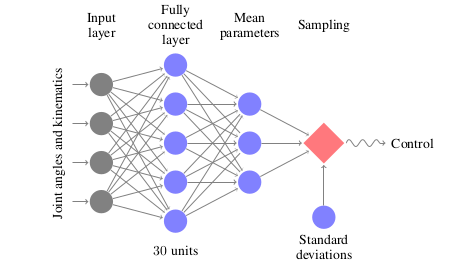

There will be two uses for such policies. One, corresponding to the current policy, which is used in interaction with the environment to control the agent. This is the standard use. The other use, corresponding to the previous policy, will only consist in computing the probability of actions according to the former policy. To implement this other use, we add the ```predict_action``` parameter to the ```forward(...)``` function.

Here is the corresponding code.

In [8]:
from torch.distributions.normal import Normal
from torch.distributions.independent import Independent

class TunableVarianceContinuousActor(BaseActor):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(layers, activation=nn.ReLU())

        # The standard deviation associated with each dimension
        self.std_param = nn.parameter.Parameter(torch.randn(action_dim, 1))
        
        # We use the softplus function to compute the variance for the normal
        # The base version computes exp(1+log(x)) component-wise
        # https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html
        self.soft_plus = torch.nn.Softplus()

    def dist(self, obs: torch.Tensor):
        mean = self.model(obs)
        return Independent(Normal(mean, self.soft_plus(self.std_param)), 1)    
            
    def forward(self, t, *, stochastic=True, predict_proba=False, compute_entropy=False, **kwargs):
        obs = self.get(("env/env_obs", t))
        dist = self.dist(obs)

        if predict_proba:
            action = self.get(("action", t))
            self.set(("logprob_predict", t), dist.log_prob(action))
        else:
            action = dist.sample() if stochastic else dist.mean
            logp_pi = dist.log_prob(action)

            self.set(("action", t), action)
            self.set(("action_logprobs", t), logp_pi)

        if compute_entropy:
            self.set(("entropy", t), dist.entropy())

    def predict_action(self, obs, stochastic):
        """Predict just one action (without using the workspace)"""
        dist = self.dist(obs)
        action = dist.sample() if stochastic else dist.mean
        return action


## Separating a training and an evaluation environment

As explained in [this notebook](https://colab.research.google.com/drive/1raeuB6uUVUpl-4PLArtiAoGnXj0sGjSV#scrollTo=Pl8HRPtsODc2), in BBRL, to implement the separation between training and evaluation, we build two environments: one for training, one for evaluation, and the same agent is connected to these two environments in two instances of TemporalAgent so that we train and evaluate the same network.

We explain how to implement this below.

### Choosing a specific gym environment

First, we need to make our gym environment. This is implemented with the simple function below.

In [9]:
def make_gym_env(env_name):
    return gym.make(env_name)

### Building the training and evaluation environments

As in previous notebooks, we build two environments: one for training and another one for evaluation.

In [10]:
def get_env_agents(cfg):
    train_env_agent = AutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.n_envs,
        cfg.algorithm.seed,
    )
    eval_env_agent = NoAutoResetGymAgent(
    get_class(cfg.gym_env),
    get_arguments(cfg.gym_env),
    cfg.algorithm.nb_evals,
    cfg.algorithm.seed,
    )
    return train_env_agent, eval_env_agent

### CriticAgent

As A2C, PPO uses a value function $V(s)$. We thus call upon the `VAgent` class,  which takes an observation as input and whose output is the value of this observation.

In [11]:
class VAgent(Agent):
    def __init__(self, state_dim, hidden_layers):
        super().__init__()
        self.is_q_function = False
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t, **kwargs):
        observation = self.get(("env/env_obs", t))
        critic = self.model(observation).squeeze(-1)
        self.set(("v_value", t), critic)

When computing the KL penalty, we need to compute the KL divergence at every time step. The KLAgent is used for this

In [12]:
class KLAgent(Agent):
    def __init__(self, model_1, model_2):
        super().__init__()
        self.model_1 = model_1
        self.model_2 = model_2

    def forward(self, t, **kwargs):
        obs = self.get(("env/env_obs", t))
        
        dist_1 = self.model_1.dist(obs)
        dist_2 = self.model_2.dist(obs)
        kl = torch.distributions.kl.kl_divergence(dist_1, dist_2)
        self.set(("kl", t), kl)

### Building the complete training and evaluation agents

A specificity of PPO with respect to other algorithms is that it needs to store the policy and the critic at the previous iteration to compute the ratio $\frac{\pi(a|s)}{\pi_{old}(a|s)}$.

The old policy corresponds to the ```old_policy``` variable. We do not need to add some exploration to it and to run it on its own in the environment.

In [13]:
# Create the PPO Agent
def create_ppo_agent(cfg, train_env_agent, eval_env_agent, needs_kl=None):
    obs_size, act_size = train_env_agent.get_obs_and_actions_sizes()

    if train_env_agent.is_continuous_action():
        action_agent = TunableVarianceContinuousActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )
    else:
        action_agent = DiscreteActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

    tr_agent = Agents(train_env_agent, action_agent)
    ev_agent = Agents(eval_env_agent, action_agent)

    critic_agent = TemporalAgent(
        VAgent(obs_size, cfg.algorithm.architecture.critic_hidden_size)
    )

    train_agent = TemporalAgent(tr_agent)
    eval_agent = TemporalAgent(ev_agent)
    train_agent.seed(cfg.algorithm.seed)

    old_policy = copy.deepcopy(action_agent)
    old_critic_agent = copy.deepcopy(critic_agent)
    
    kl_agent = None
    if needs_kl:
        kl_agent = TemporalAgent(KLAgent(old_policy, action_agent))

    return action_agent, train_agent, eval_agent, critic_agent, old_policy, old_critic_agent, kl_agent

### The Logger class

The logger class is the same as before, see [this notebook](https://colab.research.google.com/drive/1yAQlrShysj4Q9EBpYM8pBsp2aXInhP7x#scrollTo=lU3cO6znHyDc) for explanations.

In [14]:
class Logger():
    def __init__(self, cfg, variant, env_name):
        kwargs = dict(cfg.logger)
        kwargs["log_dir"] = f'{kwargs["log_dir"]}/{env_name}/{variant}-{str(time.time())}'
        self.logger = instantiate_class(kwargs)

    def add_log(self, log_string, loss, epoch):
        self.logger.add_scalar(log_string, loss.item(), epoch)

    # Log losses
    def log_losses(self, epoch, critic_loss, entropy_loss, actor_loss):
        self.add_log("critic_loss", critic_loss, epoch)
        self.add_log("entropy_loss", entropy_loss, epoch)
        self.add_log("actor_loss", actor_loss, epoch)

### Setup the optimizers

We use a single optimizer to tune the parameters of the actor and the critic. It would be possible to have two optimizers which would work separately on the parameters of each component agent, but it would be more complicated because updating the actor requires the gradient of the critic.

In [15]:
# Configure the optimizer over the a2c agent
def setup_optimizer(cfg, action_agent, critic_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = nn.Sequential(action_agent, critic_agent).parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer

### Compute critic loss

PPO uses the Generalized Advantage Estimator (GAE) defined in [this paper](https://arxiv.org/pdf/1506.02438.pdf). This approach comes with a $\lambda$ factor (here written ```cfg.algorithm.gae```) helping to find a better bias-variance compromize.

In [16]:
from bbrl.utils.functionalb import gae

def compute_advantage_loss(cfg, reward, must_bootstrap, v_value):
    # Compute temporal difference with GAE
    advantage = gae(
        v_value,
        reward,
        must_bootstrap,
        cfg.algorithm.discount_factor,
        cfg.algorithm.gae,
    )
    # Compute critic loss
    td_error = advantage**2
    critic_loss = td_error.mean()
    return critic_loss, advantage

### Compute Actor Loss

The computation of the actor loss in PPO using a clipping mechanism

$$
L ^ { C L I P } ( \theta ) = \hat { E } _ { t } [ \min ( r _ { t } ( \theta ) \hat { A } _ { t } , \operatorname { clip } ( r _ { t } ( \theta ) , 1 - \varepsilon , 1 + \varepsilon ) \hat { A } _ { t } ) ]
$$

In [17]:
def compute_clip_agent_loss(cfg, advantage, ratio, kl):
    """Computes the PPO CLIP loss
    """
    clip_range = cfg.clip_range

    # À compléter...  
    assert False, 'Code non implémenté'
    actor_loss = ...
    return actor_loss

## Main training loop

In [18]:
from bbrl.visu.visu_policies import plot_policy
from bbrl.visu.visu_critics import plot_critic

In [35]:
def run_ppo(cfg, variant="clip", compute_actor_loss=compute_clip_agent_loss, needs_kl=False):
    # 1)  Build the  logger
    logger = Logger(cfg, variant, cfg.gym_env.env_name)
    best_reward = -10e9

    # 2) Create the environment agent
    train_env_agent = AutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.n_envs,
        cfg.algorithm.seed,
    )
    
    eval_env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.nb_evals,
        cfg.algorithm.seed,
    )

    (
        policy,
        train_agent,
        eval_agent,
        critic_agent,
        old_policy,
        old_critic_agent,
        kl_agent
    ) = create_ppo_agent(cfg, train_env_agent, eval_env_agent, needs_kl=needs_kl)
    
    
    action_agent = TemporalAgent(policy)
    old_train_agent = TemporalAgent(old_policy)
    train_workspace = Workspace()

    # Configure the optimizer
    optimizer = setup_optimizer(cfg, train_agent, critic_agent)
    nb_steps = 0
    tmp_steps = 0

    # Training loop
    for epoch in range(cfg.algorithm.max_epochs):
        # Execute the agent in the workspace
        
        # Handles continuation
        delta_t = 0
        if epoch > 0:
            train_workspace.zero_grad()
            delta_t = 1
            train_workspace.copy_n_last_steps(delta_t)

        # Run the train/old_train agents
        train_agent(
            train_workspace,
            t=delta_t,
            n_steps=cfg.algorithm.n_steps - delta_t,
            stochastic=True,
            predict_proba=False,
            compute_entropy=False
        )
        old_train_agent(
            train_workspace,
            t=delta_t,
            n_steps=cfg.algorithm.n_steps - delta_t,
            # Just computes the probability
            predict_proba=True,
        )

        # Compute the critic value over the whole workspace
        critic_agent(train_workspace, n_steps=cfg.algorithm.n_steps)

        transition_workspace = train_workspace.get_transitions()
        done, truncated, reward, action, action_logp, v_value = transition_workspace[
            "env/done",
            "env/truncated",
            "env/reward",
            "action",
            "action_logprobs",
            "v_value",
        ]

        nb_steps += action[0].shape[0]

        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://colab.research.google.com/drive/1W9Y-3fa6LsPeR6cBC1vgwBjKfgMwZvP5?usp=sharing
        must_bootstrap = torch.logical_or(~done[1], truncated[1])

        with torch.no_grad():
            old_critic_agent(train_workspace, n_steps=cfg.algorithm.n_steps)
        old_action_logp = transition_workspace["logprob_predict"].detach()
        old_v_value = transition_workspace["v_value"]
        if cfg.algorithm.clip_range_vf > 0:
            # Clip the difference between old and new values
            # NOTE: this depends on the reward scaling
            v_value = old_v_value + torch.clamp(
                v_value - old_v_value,
                -cfg.algorithm.clip_range_vf,
                cfg.algorithm.clip_range_vf,
            )
            
        critic_loss, advantage = compute_advantage_loss(
            cfg, reward, must_bootstrap, v_value
        )
        
        # We store the advantage into the transition_workspace
        advantage = advantage.detach().squeeze(0)
        transition_workspace.set("advantage", 0, advantage)
        transition_workspace.set("advantage", 1, torch.zeros_like(advantage))
        transition_workspace.set_full("old_action_logprobs", transition_workspace["logprob_predict"].detach())
        transition_workspace.clear("logprob_predict")
    
        for opt_epoch in range(cfg.algorithm.opt_epochs):
            if cfg.algorithm.minibatch_size > 0:
                sample_workspace = transition_workspace.sample_subworkspace(1, cfg.algorithm.minibatch_size, 2)
            else:
                sample_workspace = transition_workspace
                                 
            if opt_epoch > 0:
                critic_loss = 0. # We don't want to optimize the critic after the first mini-epoch

            action_agent(sample_workspace, t=0, n_steps=1, compute_entropy=True, predict_proba=True)

            advantage, action_logp, old_action_logp, entropy = sample_workspace[
                "advantage",
                "logprob_predict",
                "old_action_logprobs",
                "entropy"
            ]
            advantage = advantage[0]
            act_diff = action_logp[0] - old_action_logp[0]
            ratios = act_diff.exp()

            kl = None
            if kl_agent:
                kl_agent(sample_workspace, t=0, n_steps=1)
                kl = sample_workspace["kl"][0]

            actor_loss = compute_actor_loss(
                cfg.algorithm, advantage, ratios, kl
            )
                            
            # Entropy loss favor exploration
            entropy_loss = torch.mean(entropy[0])

            # Store the losses for tensorboard display
            if opt_epoch == 0:
                # Just for the first epoch
                logger.log_losses(nb_steps, critic_loss, entropy_loss, actor_loss)

            loss = (
                cfg.algorithm.critic_coef * critic_loss
                - cfg.algorithm.actor_coef * actor_loss
                - cfg.algorithm.entropy_coef * entropy_loss
            )
            

            old_policy.copy_parameters(policy)
            old_critic_agent = copy.deepcopy(critic_agent)


            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                critic_agent.parameters(), cfg.algorithm.max_grad_norm
            )
            torch.nn.utils.clip_grad_norm_(
                train_agent.parameters(), cfg.algorithm.max_grad_norm
            )
            optimizer.step() 

        # Evaluate if enough steps have been performed
        if nb_steps - tmp_steps > cfg.algorithm.eval_interval:
            tmp_steps = nb_steps
            eval_workspace = Workspace()  # Used for evaluation
            eval_agent(
                eval_workspace,
                t=0,
                stop_variable="env/done",
                stochastic=True,
                predict_proba=False,
            )
            rewards = eval_workspace["env/cumulated_reward"][-1]
            mean = rewards.mean()
            logger.add_log("reward_mean", mean, nb_steps)
            logger.add_log("reward_max", rewards.max(), nb_steps)
            logger.add_log("reward_min", rewards.min(), nb_steps)
            logger.add_log("reward_std", rewards.std(), nb_steps)
            print(f"nb_steps: {nb_steps}, reward: {mean}")
            if cfg.save_best and mean > best_reward:
                best_reward = mean
                directory = f"./ppo_agent/{cfg.gym_env.env_name}/{variant}/"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                filename = directory + "ppo_" + str(mean.item()) + ".agt"
                policy.save_model(filename)


## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a tensorboard visualisation.

The two parameters that are specific to PPO are "clip_range" and "clip_range_vf", which are used to clip the actor loss and the critic loss respectively.

In [20]:
import my_gym

params={
  "save_best": True,
  "plot_policy": True,

  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": f"{os.getcwd()}/tblogs/ppo",
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": 4,
    "n_envs": 8,
    "max_grad_norm": 0.5,
    "nb_evals":10,
    "n_steps": 20,
    "eval_interval": 1000,
    "max_epochs": 3000,
    "discount_factor": 0.95,
    "entropy_coef": 2.55e-5,
    "beta_kl": 1,
    "critic_coef": 0.6,
    "actor_coef": 1.0,
    "gae": 0.9,
    "clip_range": 0.2,
    "clip_range_vf": 0,
    "opt_epochs": 1,
    "minibatch_size": 0,
    "architecture":{
      "actor_hidden_size": [25, 36],
      "critic_hidden_size": [24, 36],
    },
  },
  "gym_env":{
    "classname": "__main__.make_gym_env",
    "env_name": "CartPole-v1",
    },
  "optimizer":{
    "classname": "torch.optim.Adam",
    "lr": 0.001,
  }
}

### Launching tensorboard to visualize the results

# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
if get_ipython().__class__.__module__ == "google.colab._shell":
    # %load_ext tensorboard
    # %tensorboard --logdir ./tmp
else:
    import sys
    import os
    import os.path as osp
    print(f'''Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir="{params["logger"]["log_dir"]}"''')
```

```{python id="l42OUoGROlSt", tags=c()}
config=OmegaConf.create(params)
torch.manual_seed(config.algorithm.seed)
```

In [22]:
run_ppo(config)

Now we can watch our agent...

In [24]:
agent = load_agent(Path("ppo_agent") / config.gym_env.env_name / "clip", "ppo_")
play(config.gym_env.env_name, agent)

## Exercises

### 1. Optimization steps

PPO uses several optimization steps where it optimizes the loss $\mathcal L_{clip}$. This corresponds to the the setting `opt_epochs` set to a value greater than 1; in that case, you need to implement the missing code in the `run_ppo` code and take care of using the `mini_batchsize` parameter.

In [25]:
config_steps = copy.deepcopy(config)
config_steps.algorithm.opt_epochs = 10
config_steps.algorithm.minibatch_size = 64
run_ppo(config_steps, variant="clip-e10_64")

### 2. Implement PPO with the KL Penalty Coefficient

$$
\underset { \theta } { \operatorname { maximize } } \quad \hat { E } _ { t } [ \frac { \pi _ { \theta } ( a _ { t } | s _ { t } ) } { \pi _ { \theta _ { \text { old } } } ( a _ { t } | s _ { t } ) } \hat { A } _ { t } ] - \beta \hat { E } _ { t } [ KL [ \pi _ { \theta _ { \text { old } } } ( \cdot | s _ { t } ) , \pi _ { \theta } ( \cdot | s _ { t } ) ] ]
$$

In [26]:
def compute_kl_agent_loss(cfg, advantage, ratio, kl):
    """Computes the PPO KL loss
    """
    # À compléter...  
    assert False, 'Code non implémenté'
    
    actor_loss = (adv_loss - cfg.beta_kl * kl).mean()
    return actor_loss

config_kl = copy.deepcopy(config)
config_kl.algorithm.opt_epochs = 10
run_ppo(config_kl, compute_actor_loss=compute_kl_agent_loss, needs_kl=True, variant="kl-10")

### 3. Pendulum-v1

Use the same code on the Pendulum-v1 environment. This one is harder to tune. Get the parameters from the [rl-baseline3-zoo](https://github.com/DLR-RM/rl-baselines3-zoo) and see if you manage to get PPO working on Pendulum

In [36]:
config_pendulum = copy.deepcopy(config)
config_pendulum.gym_env.env_name = "Pendulum-v1"
run_ppo(config_pendulum, variant="clip")


In [49]:
agent = load_agent(Path("ppo_agent") / config_pendulum.gym_env.env_name / "clip", "ppo_")
play(make_gym_env(config_pendulum.gym_env.env_name), agent)